In [1]:
import datetime
from datetime import datetime as dt
import h5py
import matplotlib.pyplot as plt
import numpy
import numpy as np
import tables
from scipy.interpolate import interp1d

from kaeppler_chemistry import Chemistry as Chemistry

In [2]:
# Read in class
chem = Chemistry(SteadyStateTime = 100., ISRIntegrationTime = 60.)

In [3]:
def get_isr_data(pfisr_filename, pfisr_data_dir):
    """Function to get relevant data from PFISR datafile.
    INPUT
    pfisr_filename
        type: str
        about: data file name, should be .h5 file
    pfisr_data_dir
        type: str
        about: directory where isr data is stored
    OUTPUT
    utc_time
        type: array of datetimes
        about: time stamp for each measurement
    pfisr_altitude
        type: array of float
        about: altitude stamp for each measurement in meters
    e_density
        type: array of float
        about: electron number density in m^-3
    de_density
        type: array of float
        about: error in number density
    """
    
    # Read in the h5 file
    pfisr_file = h5py.File(pfisr_data_dir + pfisr_filename, 'r')

    # Get the different beams and select specified angle
    beam_angle = 90
    beams = np.array(pfisr_file['BeamCodes'])

    # Get the beam with a 90 degree elevation angle
    indexes = np.linspace(0, len(beams)-1, len(beams))
    beam_num = int(indexes[np.abs(beams[:,2] - beam_angle) == 0][0])

    # Get time and convert to utc datetime
    unix_time = np.array(pfisr_file['Time']['UnixTime'])[:,0]
    utc_time = np.array([dt.utcfromtimestamp(d) for d in unix_time])

    # Get the altitude array
    pfisr_altitude = np.array(pfisr_file['NeFromPower']
                              ['Altitude'])[beam_num, :]

    # Get the uncorrected number density array
    e_density = np.array(pfisr_file['NeFromPower']
                         ['Ne_NoTr'])[:, beam_num, :]

    # Take the transpose
    e_density = np.transpose(e_density)
    
    # Find the noise floor by averaging between 55km and 60km
    #...assume this should be zero
    noise_floor = np.mean(e_density[(pfisr_altitude > 55000)
                                    & (pfisr_altitude < 60000), :],
                          axis=0)
    
    # Loop through each column and subtract off noise floor
    for j in range(e_density.shape[1]):
        e_density[:, j] = e_density[:, j] - noise_floor[j]
    
    # Get error values
    de_density = np.array(pfisr_file['NeFromPower']
                          ['errNe_NoTr'])[:, beam_num, :]
    de_density = np.transpose(de_density)

    # Close file
    pfisr_file.close()
    
    return utc_time, unix_time, pfisr_altitude, e_density, de_density

In [6]:
# Read in pfisr data
pfisr_data_dir = '../source-energy-pa/data/pfisr-data/mswinds/'
pfisr_filename = '20161013.003_bc_nenotr_1min.h5'
(utc_time, unix_time,
 pfisr_altitude, e_density, de_density) = get_isr_data(pfisr_filename, pfisr_data_dir)

# Convert to correct units, needs to be in cgs
Ne = e_density/1e6
dNe = de_density/1e6
Alt = pfisr_altitude/1000

# Latitude and longitude of instrument
glat = 65.12992
glon = -147.47104

In [7]:
altitude_bins = np.linspace(60e3, 144e3, 100)
alt_min = min(altitude_bins)
alt_max = max(altitude_bins)
alt_step = altitude_bins[1] - altitude_bins[0]

In [8]:
# Specify time slice
slice_n = 151

# Create an interpolation of the pfisr electron density
e_density_interp = interp1d(pfisr_altitude, e_density[:, slice_n])

In [9]:
# OK so now run the initialization to get the background ionosphere 
#...in the D-region
#...altitudes need to be input in km, time is unix
chem.Set_Inital_Ionization(unix_time[slice_n], glat, glon,
                           alt_min/1000, alt_max/1000, alt_step/1000)

In [10]:
# Run the chemistry code to convert electron density to ionization rate.
#...make sure to run initial ionziation code first
#...input should be in km and 1/cm^3
#...this will output in units of cgs
q_estimate = chem.Calculate_Ionization_From_Ne(altitude_bins/1000,
                                    e_density_interp(altitude_bins)/1e6,
                                    chem.DregionChem)

In [11]:
# convert to SI
qz_estimate_SI = q_estimate*1e6

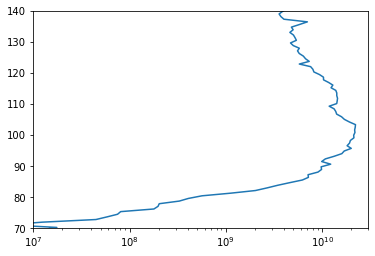

In [12]:
plt.plot(qz_estimate_SI, altitude_bins/1000)
plt.ylim(70, 140)
plt.xlim(1e7, 3e10)
plt.xscale('log')

In [11]:
q_estimate

array([5.18096352e+00, 0.00000000e+00, 2.05546284e+00, 7.65072250e+00,
       0.00000000e+00, 0.00000000e+00, 4.95403051e-01, 7.50927544e+00,
       1.77299423e+01, 1.54228592e+01, 0.00000000e+00, 1.16058846e+01,
       1.75486679e+01, 5.41809273e+00, 1.23777122e+01, 4.47035065e+01,
       5.82535553e+01, 7.49271545e+01, 8.07648010e+01, 1.78794739e+02,
       1.97292419e+02, 2.02969421e+02, 3.28106079e+02, 4.07513062e+02,
       5.65015381e+02, 1.12204834e+03, 2.02521191e+03, 2.67603223e+03,
       3.45659277e+03, 4.61863086e+03, 6.23156836e+03, 7.19051367e+03,
       7.13291992e+03, 9.04160547e+03, 9.84926953e+03, 9.75286328e+03,
       1.22569414e+04, 9.88380078e+03, 1.07836367e+04, 1.33208633e+04,
       1.60033828e+04, 1.69402422e+04, 2.00351797e+04, 1.81488828e+04,
       1.92308047e+04, 1.96252266e+04, 2.13589297e+04, 2.12418984e+04,
       2.18866328e+04, 2.17346172e+04, 2.20350234e+04, 2.21766641e+04,
       1.92013672e+04, 1.70035703e+04, 1.58723828e+04, 1.41313633e+04,
      